In [1]:
!pip install SpeechRecognition jiwer pandas datasets accelerate torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
!pip install openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 36.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.4 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803320 sha256=bc78fd3745c5610067f80e018ee3e90ba206b5e71a96c713548fc343ae1479e4
  Stored in directory: /root/.cache/pip/wheels/dd/4a/1f/d1c4bf3b9133c8168fe617ed979cab7b14fe381d059ffb9d83
Successfully built openai-whisper


In [3]:
import speech_recognition as sr
import whisper
import jiwer
import pandas as pd
from datasets import Dataset, load_dataset, Audio
import os
import accelerate
import torch

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
csv_path = '/content/drive/MyDrive/sample_dataset/filtered_csv_file.csv'


In [6]:
audio_folder_path = '/content/drive/MyDrive/sample_dataset/train'

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# code to remove path and keep only filename in file_name column

import re
df = pd.read_csv(csv_path)

def clean_file_name(file_name):
    # Extract the filename part after the last slash or backslash
    return re.sub(r'.*[\\/]', '', file_name)

# Apply the cleaning function to File_name column
df['file_name'] = df['file_name'].apply(clean_file_name)

# Save the updated DataFrame back to the CSV
df.to_csv(csv_path, index=False)

In [9]:
df['file_name'] = df['file_name'].apply(lambda x: os.path.abspath(os.path.join(audio_folder_path, os.path.basename(x))))

In [10]:
df.to_csv(csv_path, index=False)

In [11]:
dataset = load_dataset('csv', data_files=csv_path)

Generating train split: 0 examples [00:00, ? examples/s]

In [12]:
dataset = dataset.cast_column('file_name', Audio(sampling_rate=16000))

In [13]:
dataset = dataset.rename_column('file_name', 'audio')
dataset = dataset.rename_column('phrase', 'sentence')

In [14]:
from transformers import WhisperProcessor

In [15]:
from datasets import Audio
from transformers import WhisperProcessor

# Load the processor
processor = WhisperProcessor.from_pretrained("openai/whisper-base")

# Ensure audio column is cast to Audio with the correct sampling rate
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

# Define the prepare_dataset function with error handling
# def prepare_dataset(batch):
#     try:
#         # Check if 'audio' and 'phrase' are present and not None
#         if batch.get("audio") and batch.get("phrase"):
#             # Process audio to input features
#             batch["input_features"] = processor(batch["audio"]["array"], sampling_rate=16000).input_features[0]
#             # Process transcription to labels
#             batch["labels"] = processor.tokenizer(batch["phrase"]).input_ids
#         else:
#             # Skip this batch if audio or phrase is missing
#             print(f"Skipping batch with missing audio or phrase: {batch}")
#     except KeyError as e:
#         print(f"Key error: {e}. The 'audio' data may be missing or not loaded properly.")
#     except Exception as e:
#         print(f"An error occurred: {e}")
#     return batch
def prepare_dataset(batch):
    # Process audio to input features
    batch["input_features"] = processor(batch["audio"]["array"], sampling_rate=16000).input_features[0]
    # Process transcription to labels
    batch["labels"] = processor.tokenizer(batch["sentence"]).input_ids
    return batch


# Retrieve the current columns of the dataset (adjust "train" as needed if working with a specific split)
# current_columns = dataset.column_names  # or dataset["train"].column_names if using a split

# Dynamically adjust the columns to remove based on availability
columns_to_remove = [
    'audio_clipping', 'audio_clipping:confidence', 'background_noise_audible',
    'background_noise_audible:confidence', 'overall_quality_of_the_audio',
    'quiet_speaker', 'quiet_speaker:confidence', 'speaker_id', 'file_download',
    'prompt', 'writer_id'
]

# Now, apply the map function with the filtered list of columns to remove
dataset = dataset.map(prepare_dataset, remove_columns=columns_to_remove)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

In [16]:
# from google.colab import drive
# drive.mount('/content/drive')

In [17]:
from transformers import WhisperForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from torch.nn.utils.rnn import pad_sequence

In [18]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.81k [00:00<?, ?B/s]

In [19]:
training_args = Seq2SeqTrainingArguments(
    output_dir="whisper-finetuned",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,
    num_train_epochs=3,
    fp16=False,
    save_steps=100,
    logging_steps=10,
    eval_strategy="steps",  # Changed from evaluation_strategy to eval_strategy
    eval_steps=100,
    save_total_limit=2,
)


In [20]:
class DataCollatorForWhisper:
    def __call__(self, features):

        input_features = [torch.tensor(feature["input_features"]) for feature in features]
        labels = [torch.tensor(feature["labels"]) for feature in features]


        input_features_padded = pad_sequence(input_features, batch_first=True, padding_value=0)
        labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)

        return {
            "input_features": input_features_padded,
            "labels": labels_padded
        }

In [21]:
data_collator = DataCollatorForWhisper()

In [22]:
training_args = Seq2SeqTrainingArguments(
    output_dir="whisper-finetuned",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,
    num_train_epochs=3,
    fp16=False,
    save_steps=100,
    logging_steps=10,
    evaluation_strategy="no",  # Disable evaluation
    save_total_limit=2,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
# from google.colab import drive
# drive.mount('/content/drive')


In [24]:
# dataset_path = "/content/drive/MyDrive/sample_dataset"


In [25]:
# from datasets import load_dataset, Audio

# # Define the dataset path
# dataset_path = "/content/drive/MyDrive/sample_dataset"

# # Load the dataset
# dataset = load_dataset("csv", data_files={
#      "train": f"{dataset_path}/filtered_csv_file.csv",  # Your actual train file name
#     "validation": f"{dataset_path}/filtered_csv_file.csv"
# })

# # If your dataset has audio files, ensure to specify the audio column
# dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))


In [26]:
# from transformers import WhisperProcessor

In [27]:
# def prepare_dataset(batch):
#     # Check if audio data is valid
#     if batch.get("audio") and batch["audio"].get("array") is not None:
#         # Process audio to input features
#         batch["input_features"] = processor(batch["audio"]["array"], sampling_rate=16000).input_features[0]
#         # Process transcription to labels
#         batch["labels"] = processor.tokenizer(batch["phrase"]).input_ids  # Use 'phrase' or correct text column
#     else:
#         # Handle missing audio data
#         batch["input_features"] = None
#         batch["labels"] = None
#     return batch


In [28]:
# dataset = dataset.map(prepare_dataset, remove_columns=columns_to_remove)


In [29]:
# from transformers import WhisperForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
# from torch.nn.utils.rnn import pad_sequence

In [30]:
# model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")

In [31]:
# training_args = Seq2SeqTrainingArguments(
#     output_dir="whisper-finetuned",
#     per_device_train_batch_size=8,
#     gradient_accumulation_steps=4,
#     learning_rate=1e-5,
#     num_train_epochs=3,
#     fp16=False,
#     save_steps=100,
#     logging_steps=10,
#     eval_strategy="steps",  # Changed from evaluation_strategy to eval_strategy
#     eval_steps=100,
#     save_total_limit=2,
# )


In [32]:
# from torch.nn.utils.rnn import pad_sequence
# import torch

# class DataCollatorForWhisper:
#     def __call__(self, features):
#         input_features = [torch.tensor(feature["input_features"]) for feature in features]
#         labels = [torch.tensor(feature["labels"]) for feature in features]

#         input_features_padded = pad_sequence(input_features, batch_first=True, padding_value=0)
#         labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)

#         return {
#             "input_features": input_features_padded,
#             "labels": labels_padded
#         }


In [33]:
# data_collator = DataCollatorForWhisper()

In [34]:
 trainer = Seq2SeqTrainer(
    model=model,
     args=training_args,
    train_dataset=dataset['train'],
     tokenizer=processor.tokenizer,
     data_collator=data_collator,
 )

<ipython-input-34-0763a4afe7b7>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [35]:
# def is_valid(batch):
#     return batch["input_features"] is not None and batch["labels"] is not None

# # Apply the processing function
# dataset = dataset.map(prepare_dataset, remove_columns=columns_to_remove)

# # Filter out invalid entries
# dataset = dataset.filter(is_valid)


In [36]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=3, training_loss=6.604160308837891, metrics={'train_runtime': 56.9914, 'train_samples_per_second': 2.421, 'train_steps_per_second': 0.053, 'total_flos': 5967119646720000.0, 'train_loss': 6.604160308837891, 'epoch': 2.0})

In [37]:
from diffusers import StableDiffusionPipeline
from torch import autocast

In [38]:
sd_model_id = "stabilityai/stable-diffusion-2-1"

In [39]:
!pip install matplotlib


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

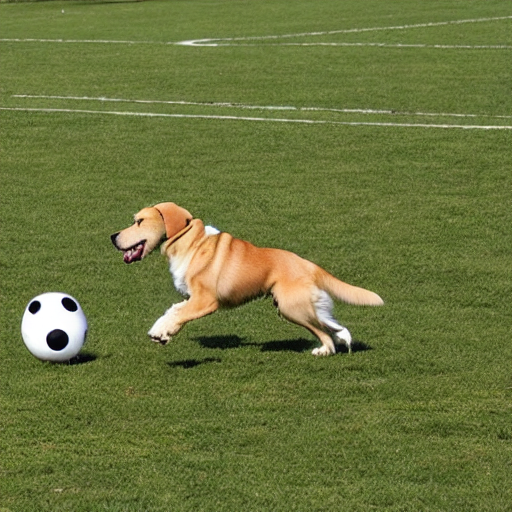

In [40]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
from IPython.display import display

# Initialize model
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"  # or "cpu" if you don't have GPU

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

# Generate image
prompt = "dogs playing football"
image = pipe(prompt).images[0]

# Save the image
image.save("astronaut_rides_horse.png")

# Open and display the saved image
saved_image = Image.open("astronaut_rides_horse.png")
display(saved_image)


In [41]:
!pip install flask openai pyngrok


In [42]:
!ngrok config add-authtoken 2opywyqu3go4hjyQrWHUYGYdD0p_5dQjeF1t7tHGaX1xKG5UR


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [43]:
from pyngrok import ngrok

# Start ngrok tunnel
public_url = ngrok.connect(5000)
print("Public URL:", public_url)


Public URL: NgrokTunnel: "https://fa4e-34-126-93-69.ngrok-free.app" -> "http://localhost:5000"


In [44]:
!pip uninstall openai -y


Found existing installation: openai 1.54.4
Uninstalling openai-1.54.4:
  Successfully uninstalled openai-1.54.4


In [45]:
!pip install openai==0.28


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 7.1 MB/s eta 0:00:00


In [46]:
pip install torch diffusers fastapi uvicorn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.5 MB/s eta 0:00:00


In [55]:
# Install necessary packages
!pip install fastapi uvicorn python-multipart diffusers torch transformers pillow pyngrok nest_asyncio

from fastapi import FastAPI, UploadFile, File
from fastapi.responses import JSONResponse
from pydantic import BaseModel
from pyngrok import ngrok
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image
import nest_asyncio
import subprocess

# Apply nest_asyncio for Jupyter notebook compatibility
nest_asyncio.apply()

# Initialize FastAPI app
app = FastAPI()

# Initialize Stable Diffusion model
model_id = "stabilityai/stable-diffusion-2-1"
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

# Define request schema for text prompt
class GenerateRequest(BaseModel):
    description_text: str

# Endpoint 1: Generate image from text prompt
@app.post("/generate_image/")
async def generate_image(request: GenerateRequest):
    try:
        # Extract the description_text from the request body
        description_text = request.description_text
        # Generate the image
        image = pipe(description_text).images[0]
        image_path = "/content/generated_image.png"
        image.save(image_path)
        return {"message": "Image generated successfully!", "image_path": image_path}
    except Exception as e:
        return JSONResponse(status_code=500, content={"error": str(e)})

# Endpoint 2: Transcribe audio and generate image (with Whisper integration placeholder)
@app.post("/transcribe_and_generate/")
async def transcribe_and_generate(file: UploadFile = File(...)):
    def transcribe_audio(file_path):
        # Placeholder for Whisper transcription logic
        return "Transcribed text from audio"

    try:
        # Save the uploaded file
        file_path = f"/content/{file.filename}"
        with open(file_path, "wb") as f:
            f.write(await file.read())

        # Transcribe the audio using Whisper (replace with real logic)
        transcription = transcribe_audio(file_path)

        # Generate an image based on the transcription
        image = pipe(transcription).images[0]
        image_path = "/content/generated_image_from_transcription.png"
        image.save(image_path)

        return {
            "message": "Image generated successfully from transcription!",
            "transcription": transcription,
            "image_path": image_path
        }
    except Exception as e:
        return JSONResponse(status_code=500, content={"error": str(e)})

# Expose API via ngrok
public_url = ngrok.connect(8000)
print(f"Public URL: {public_url}")

# Run the server
subprocess.Popen(["uvicorn", "--host", "0.0.0.0", "--port", "8000", "InfosysProject:app"])


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Public URL: NgrokTunnel: "https://5b38-34-126-93-69.ngrok-free.app" -> "http://localhost:8000"


<Popen: returncode: None args: ['uvicorn', '--host', '0.0.0.0', '--port', '8...>